In [63]:
from attention import AttentionLayer
import pandas as pd
import numpy as np
import scipy as sp
import re
from bs4 import BeautifulSoup
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense, Bidirectional, Input, Embedding, Concatenate
from tensorflow.keras.models import Model
import os
import collections
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


<h2> Data Preprocessing </h2>

In [17]:
indices = collections.deque()
for path, dirs, files in os.walk("data"):
    if len(dirs)==0:
        stem = path.split("/")[-1]+"/"
        for file in files:
            indices.append(stem+file)
newsdf = pd.DataFrame(index=np.unique(indices), columns=["Text", "Summary", "Category"])

In [18]:
newsdf.Category = np.vectorize(lambda s: s.split("/")[0])(newsdf.index.values)
for path, dirs, files in os.walk("data"):
    if len(dirs)==0:
        stem = path.split("/")[-1]+"/"
        col = "Text" if "articles" in path else "Summary"
        for file in files:
            newsdf.loc[stem+file, col] = open(path+"/"+file, "rb").read()

In [19]:
def bytedecoder(string):
    try:
        string = string.decode('utf-8')
        return string
    except:
        return np.nan
for col in ['Text', 'Summary']:
    newsdf[col] = newsdf[col].apply(bytedecoder)
newsdf.dropna(how="any", inplace=True)
newsdf.drop_duplicates(inplace=True)

In [26]:
def cleaner(s):
    s = re.sub("\n"," ", re.sub("[?.,<>@#\'\"]","", s))
    return BeautifulSoup(s, "lxml").text.lower()
for col in ['Text', 'Summary']:
    newsdf[col] = newsdf[col].apply(cleaner)
newsdf['Summary'] = "<START> "+newsdf['Summary']+" <END>"

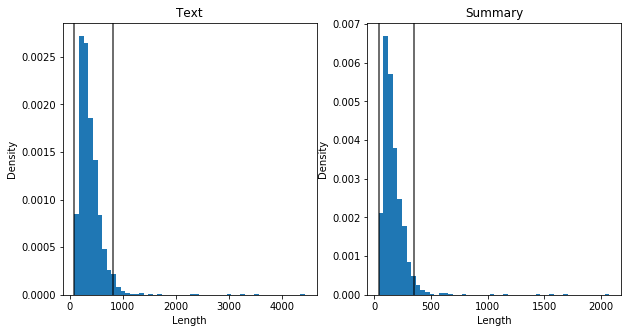

In [39]:
plt.figure(figsize=(10,5))
for col, plot in [('Text', 1), ('Summary', 2)]:
    plt.subplot(1,2,plot)
    lengths = newsdf[col].apply(lambda s: len(s.split()))
    plt.hist(lengths, bins=50, density=True)
    quants = lengths.quantile([0.25,0.75])
    plt.axvline(np.maximum(np.min(lengths), quants[0.25]-1.5*quants.diff().values[-1]), color="black", alpha=0.75)
    plt.axvline(quants[0.75]+1.5*quants.diff().values[-1], color="black", alpha=0.75)
    plt.xlabel("Length")
    plt.ylabel("Density")
    plt.title(col)

In [41]:
#Set maximum lengths at 1000 for text and 500 for summary, and remove any exceeding entries
MAX_TEXT_LEN = 1000
MAX_SUMMARY_LEN = 500
newsdf.drop(newsdf[(newsdf['Text'].apply(lambda s: len(s.split()))>MAX_TEXT_LEN)|(newsdf['Summary'].apply(
    lambda s: len(s.split()))>MAX_SUMMARY_LEN)].index, inplace=True)

In [47]:
token = keras.preprocessing.text.Tokenizer()
alltext = newsdf['Text'].append(newsdf['Summary']).values
token.fit_on_texts(alltext)
texts = token.texts_to_sequences(newsdf['Text'])
summs = token.texts_to_sequences(newsdf['Summary'])
texts = keras.preprocessing.sequence.pad_sequences(texts, maxlen=MAX_TEXT_LEN, padding="post")
summs = keras.preprocessing.sequence.pad_sequences(summs, maxlen=MAX_SUMMARY_LEN, padding="post")

In [57]:
np.random.seed(1)
testindices = np.random.choice(np.arange(texts.shape[0]), np.int(0.2*texts.shape[0]), replace=False)
trainindices = np.unique(list(set(np.arange(texts.shape[0]))-set(testindices)))
trainX, testX = texts[trainindices], texts[testindices]
trainY, testY = summs[trainindices], summs[testindices]
trainX.shape, trainY.shape, testX.shape, testY.shape

((1682, 1000), (1682, 500), (420, 1000), (420, 500))

<h2> Model Design </h2>

In [66]:
lstmdim = 500
keras.backend.clear_session()
#Encoder
textinput = Input(shape=(MAX_TEXT_LEN,))
textembed = Embedding(len(token.word_index)+1, lstmdim, trainable=True)(textinput)
encout1, _, _ = LSTM(lstmdim, return_sequences=True, return_state=True)(textembed)
encout2, _, _ = LSTM(lstmdim, return_sequences=True, return_state=True)(encout1)
encout3, enc_h, enc_c = LSTM(lstmdim, return_sequences=True, return_state=True)(encout2)
#Decoder
summinput = Input(shape=(None,))
summembed = Embedding(len(token.word_index)+1, lstmdim, trainable=True)(summinput)
decout, _, _ = LSTM(lstmdim, return_sequences=True, return_state=True)(summembed, initial_state=[enc_h, enc_c])
#Attention Consolidation
attnout, _ = AttentionLayer(name="attention")([encout3, decout])
concat = Concatenate(axis=-1, name="concat")([decout, attnout])
preds = TimeDistributed(Dense(len(token.word_index)+1, activation="softmax"))(concat)
mdl = Model(inputs=[textinput, summinput], outputs=preds)
mdl.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
mdl.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1000, 500)    21126000    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 1000, 500),  2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
check = tf.keras.callbacks.ModelCheckpoint("./data/newsseq2seq.h5", save_best_only=True, 
                                           monitor="val_loss", freq="epoch")
hist = mdl.fit([trainX, trainY[:,:-1]], trainY.reshape(trainY.shape[0], trainY.shape[1], 1)[:,1:], epochs=20, 
               callbacks=[check], batch_size=512, verbose=True, 
               validation_data=([testX, testY[:,:-1]], testY.reshape(testY.shape[0], testY.shape[1], 1)[:,1:]))

Train on 1682 samples, validate on 420 samples
Epoch 1/20
